<a href="https://colab.research.google.com/github/emilyjiminroh/Music_Video_Generator-MuLife/blob/main/mulife_genre_classification_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset (GTZAN): https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification

# 데이터셋 다운로드

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'username' # username
os.environ['KAGGLE_KEY'] = 'key' # key

In [ ]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

100% 1.21G/1.21G [00:16<00:00, 51.4MB/s]
100% 1.21G/1.21G [00:17<00:00, 76.5MB/s]


In [ ]:
!unzip -q gtzan-dataset-music-genre-classification.zip

# 오디오 파일 이해하기

- y: 소리가 떨리는 세기(진폭)를 시간 순서대로 나열한 것
- Sampling rate: 1초당 샘플의 개수, 단위 Hz 또는 kHz (음질
)



In [ ]:
import librosa

y, sr = librosa.load('Data/genres_original/reggae/reggae.00036.wav')

print(y)
print(len(y))
print('Sampling rate (Hz): %d' % sr)
print('Audio length (seconds): %.2f' % (len(y) / sr))

[0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388]
661794
Sampling rate (Hz): 22050
Audio length (seconds): 30.01


# 음악 분석하기
## 음악 들어보기


In [ ]:
import IPython.display as ipd

ipd.Audio(y, rate=sr)

## 2D 음파 그래프

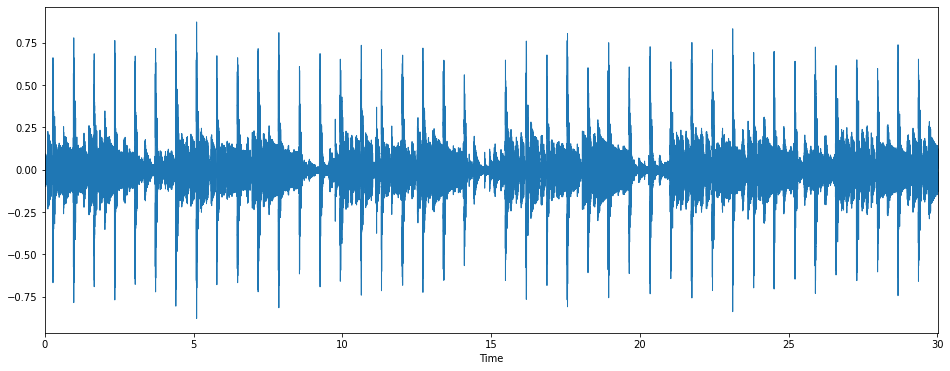

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(16, 6))
librosa.display.waveplot(y=y, sr=sr)
plt.show()

## Fourier Transform

**음도 결국엔 수로 이루어진 데이터!!!!!**
- 시간 영역 데이터를 주파수 영역으로 변경
- y축: 주파수 (로그 스케일)
- color축: 데시벨 (진폭)

(1025, 1293)


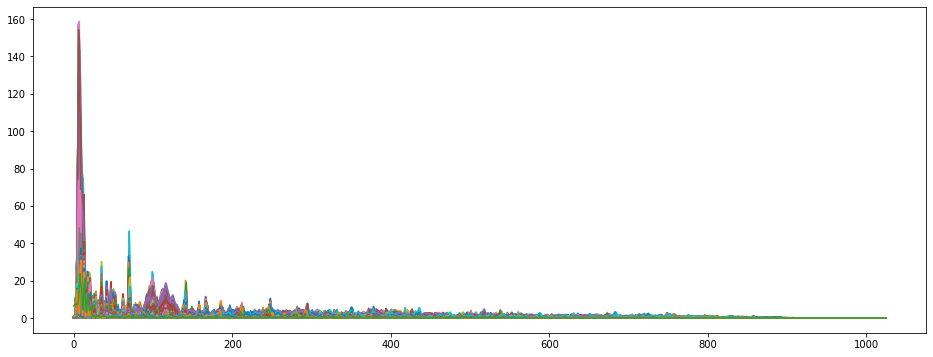

In [ ]:
import numpy as np

D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))

print(D.shape)

plt.figure(figsize=(16, 6))
plt.plot(D)
plt.show()

## Spectogram

- 시간에 따른 신호 주파수의 스펙트럼 그래프
- 다른 이름: Sonographs, Voiceprints, Voicegrams

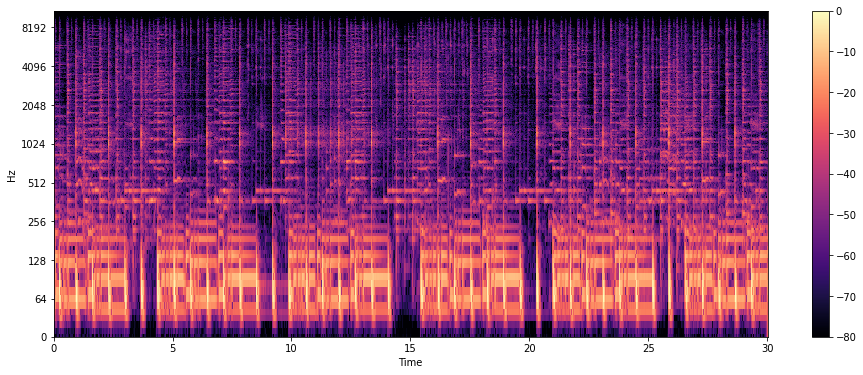

In [ ]:
DB = librosa.amplitude_to_db(D, ref=np.max)

plt.figure(figsize=(16, 6))
librosa.display.specshow(DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

## Mel Spectogram

- (인간이 이해하기 힘든) Spectogram의 y축을 Mel Scale로 변환한 것 (Non-linear transformation)
- Mel Scale: https://newsight.tistory.com/294

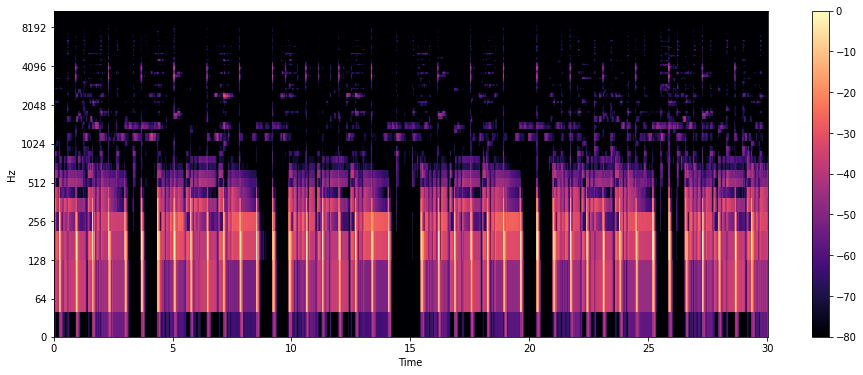

In [ ]:
S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize=(16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

## 레게 vs 클래식 Mel Spectogram

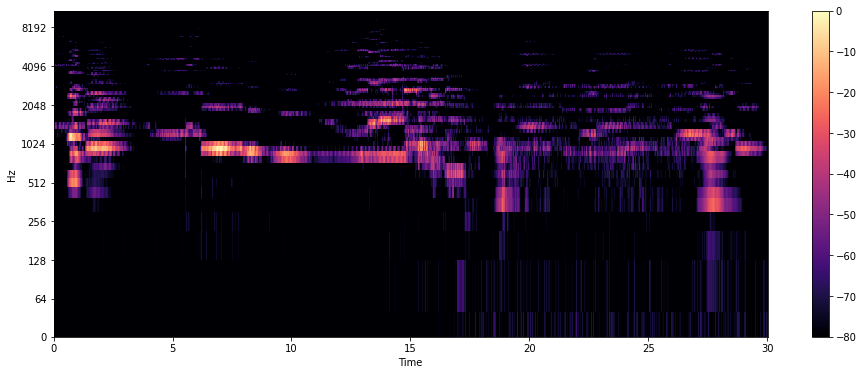

In [ ]:
y, sr = librosa.load('Data/genres_original/classical/classical.00036.wav')
y, _ = librosa.effects.trim(y)


S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis = 'time', y_axis = 'log')
plt.colorbar()
plt.show()

# 오디오 특성 추출 (Audio Feature Extraction)

## Tempo (BPM)

In [ ]:
tempo, _ = librosa.beat.beat_track(y, sr=sr)
print(tempo)

107.666015625


## Zero Crossing Rate

- 음파가 양에서 음으로 또는 음에서 양으로 바뀌는 비율

In [ ]:
zero_crossings = librosa.zero_crossings(y, pad=False)

print(zero_crossings)
print(sum(zero_crossings))

[False False False ... False False False]
39405


### 확대해서 보자

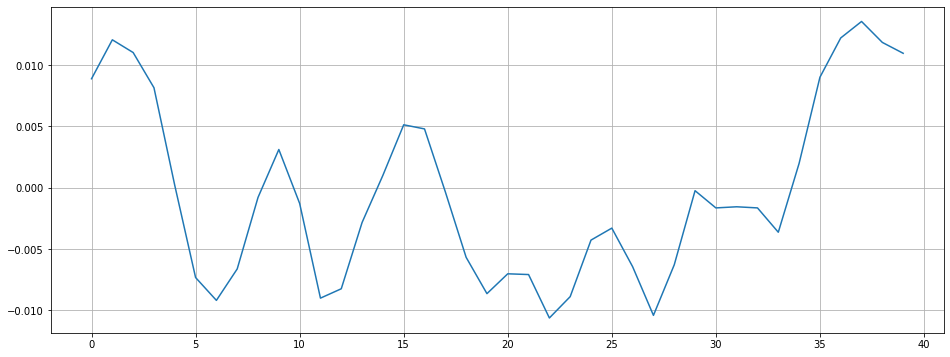

In [ ]:
n0 = 9000
n1 = 9040

plt.figure(figsize=(16, 6))
plt.plot(y[n0:n1])
plt.grid()
plt.show()

In [ ]:
zero_crossings = librosa.zero_crossings(y[n0:n1], pad=False)
print(sum(zero_crossings))

6


## Harmonic and Percussive Components

- Harmonics: 사람의 귀로 구분할 수 없는 특징들 (음악의 색깔)
- Percussives: 리듬과 감정을 나타내는 충격파

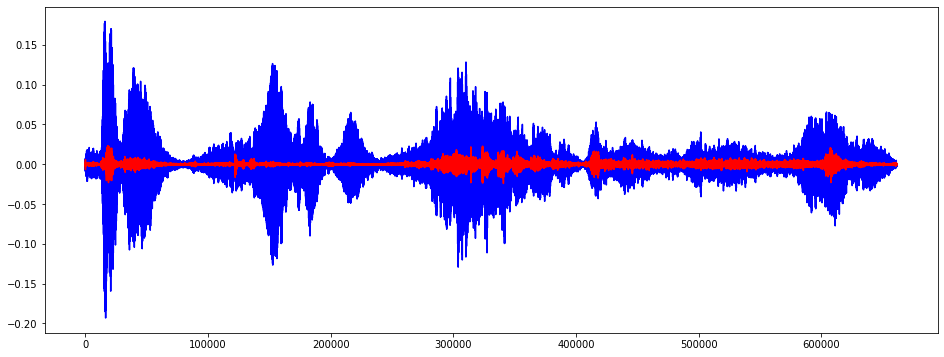

In [ ]:
y_harm, y_perc = librosa.effects.hpss(y)

plt.figure(figsize=(16, 6))
plt.plot(y_harm, color='b')
plt.plot(y_perc, color='r')
plt.show()

## Spectral Centroid

- 소리를 주파수 표현했을 때, 주파수의 가중평균을 계산하여 소리의 "무게 중심"이 어딘지를 알려주는 지표
- 예를 들어, 블루스 음악은 무게 중심이 가운데 부분에 놓여있는 반면, 메탈 음악은 (끝 부분에서 달리기 때문에) 노래의 마지막 부분에 무게 중심이 실린다

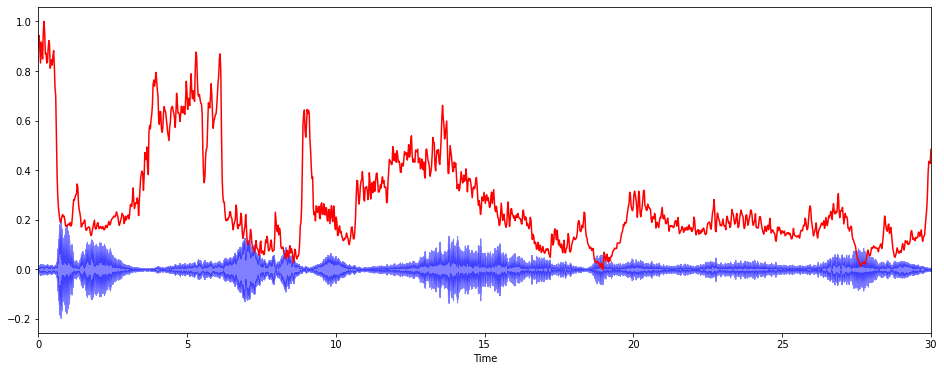

In [ ]:
spectral_centroids = librosa.feature.spectral_centroid(y, sr=sr)[0]

# Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

import sklearn
def normalize(x, axis=0):
  return sklearn.preprocessing.minmax_scale(x, axis=axis)

plt.figure(figsize=(16, 6))
librosa.display.waveplot(y, sr=sr, alpha=0.5, color='b')
plt.plot(t, normalize(spectral_centroids), color='r')
plt.show()

# Spectral Rolloff

- 신호 모양을 측정한다
- 총 스펙트럴 에너지 중 낮은 주파수(85% 이하)에 얼마나 많이 집중되어 있는가

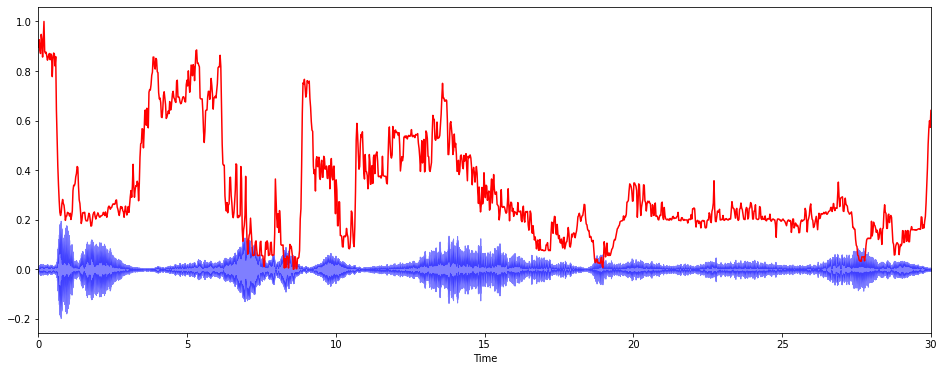

In [ ]:
spectral_rolloff = librosa.feature.spectral_rolloff(y, sr=sr)[0]

plt.figure(figsize=(16, 6))
librosa.display.waveplot(y, sr=sr, alpha=0.5, color='b')
plt.plot(t, normalize(spectral_rolloff), color='r')
plt.show()

## Mel-Frequency Cepstral Coefficients (MFCCs)

- MFCCs는 특징들의 작은 집합(약 10-20)으로 스펙트럴 포곡선의 전체적인 모양을 축약하여 보여준다
- 사람의 청각 구조를 반영하여 음성 정보 추출
- https://tech.kakaoenterprise.com/66

mean: 0.48
var: 0.04


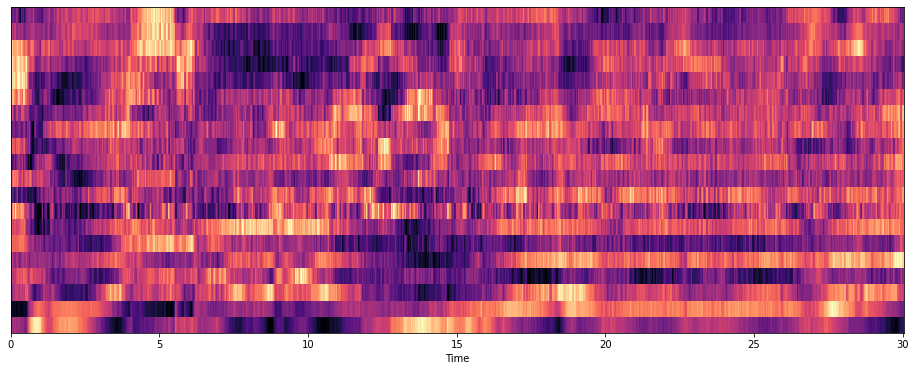

In [ ]:
mfccs = librosa.feature.mfcc(y, sr=sr)
mfccs = normalize(mfccs, axis=1)

print('mean: %.2f' % mfccs.mean())
print('var: %.2f' % mfccs.var())

plt.figure(figsize=(16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.show()

## Chroma Frequencies

- 크로마 특징은 음악의 흥미롭고 강렬한 표현이다
- 크로마는 인간 청각이 옥타브 차이가 나는 주파수를 가진 두 음을 유사음으로 인지한다는 음악이론에 기반한다
- 모든 스펙트럼을 12개의 Bin으로 표현한다
- 12개의 Bin은 옥타브에서 12개의 각기 다른 반음(Semitones=Chroma)을 의미한다

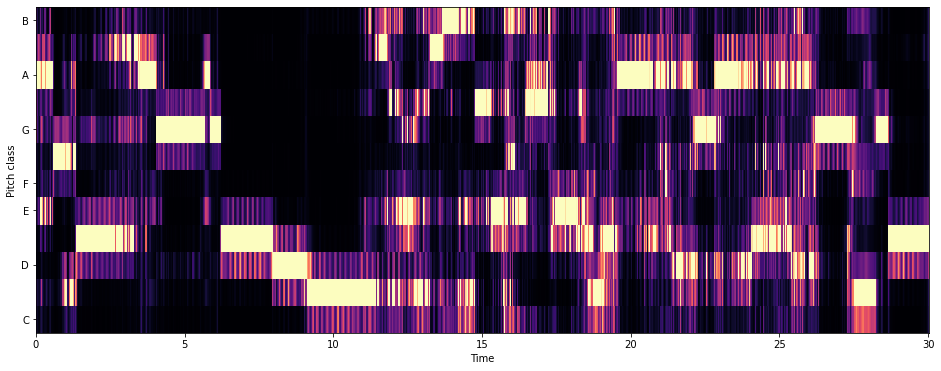

In [ ]:
chromagram = librosa.feature.chroma_stft(y, sr=sr, hop_length=512)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512)
plt.show()

# 학습

## 데이터셋 로드

In [ ]:
import pandas as pd

df = pd.read_csv('Data/features_3_sec.csv')

df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


## 전처리

In [ ]:
X = df.drop(columns=['filename', 'length', 'label'])
y = df['label']

scaler = sklearn.preprocessing.MinMaxScaler()
np_scaled = scaler.fit_transform(X)

X = pd.DataFrame(np_scaled, columns=X.columns)

X.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.355399,0.716757,0.293133,0.107955,0.262173,0.034784,0.459205,0.094130,0.346153,0.083164,...,0.363613,0.056198,0.397172,0.066062,0.371828,0.055344,0.380831,0.026797,0.506746,0.047781
1,0.367322,0.670347,0.253040,0.044447,0.270969,0.018716,0.470831,0.052261,0.363722,0.051694,...,0.468596,0.092912,0.351681,0.074001,0.362068,0.076365,0.418452,0.082414,0.593029,0.065548
2,0.373159,0.728067,0.296753,0.141663,0.265293,0.023073,0.494051,0.059922,0.378215,0.060820,...,0.479681,0.096704,0.420979,0.050639,0.400536,0.067509,0.433742,0.043841,0.546264,0.036062
3,0.399349,0.677066,0.298024,0.075042,0.238427,0.023187,0.455246,0.066234,0.329587,0.070906,...,0.386258,0.067995,0.387474,0.050617,0.380430,0.050030,0.405824,0.041898,0.562204,0.034873
4,0.355668,0.689113,0.322308,0.052149,0.233460,0.016451,0.451651,0.047830,0.318453,0.046916,...,0.438567,0.042500,0.460314,0.083860,0.388590,0.076524,0.409019,0.020763,0.517913,0.031713


## 데이터셋 분할

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7992, 57) (7992,)
(1998, 57) (1998,)


## 학습 및 검증

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train)

y_preds = xgb.predict(X_test)

print('Accuracy: %.2f' % accuracy_score(y_test, y_preds))

Accuracy: 0.88


## Confusion Matrix

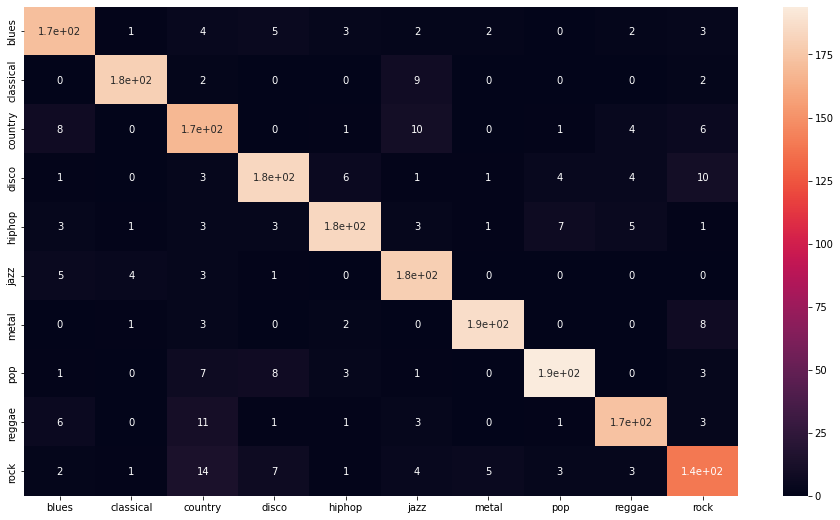

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_preds)

plt.figure(figsize=(16, 9))
sns.heatmap(
    cm,
    annot=True, 
    xticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
    yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
)
plt.show()

In [ ]:
for feature, importance in zip(X_test.columns, xgb.feature_importances_):
  print('%s: %.2f' % (feature, importance))

chroma_stft_mean: 0.04
chroma_stft_var: 0.03
rms_mean: 0.02
rms_var: 0.03
spectral_centroid_mean: 0.02
spectral_centroid_var: 0.02
spectral_bandwidth_mean: 0.05
spectral_bandwidth_var: 0.01
rolloff_mean: 0.02
rolloff_var: 0.03
zero_crossing_rate_mean: 0.02
zero_crossing_rate_var: 0.01
harmony_mean: 0.02
harmony_var: 0.02
perceptr_mean: 0.02
perceptr_var: 0.08
tempo: 0.02
mfcc1_mean: 0.02
mfcc1_var: 0.03
mfcc2_mean: 0.01
mfcc2_var: 0.01
mfcc3_mean: 0.01
mfcc3_var: 0.02
mfcc4_mean: 0.04
mfcc4_var: 0.02
mfcc5_mean: 0.01
mfcc5_var: 0.03
mfcc6_mean: 0.02
mfcc6_var: 0.01
mfcc7_mean: 0.01
mfcc7_var: 0.03
mfcc8_mean: 0.01
mfcc8_var: 0.01
mfcc9_mean: 0.02
mfcc9_var: 0.01
mfcc10_mean: 0.01
mfcc10_var: 0.01
mfcc11_mean: 0.01
mfcc11_var: 0.01
mfcc12_mean: 0.03
mfcc12_var: 0.01
mfcc13_mean: 0.01
mfcc13_var: 0.01
mfcc14_mean: 0.01
mfcc14_var: 0.01
mfcc15_mean: 0.01
mfcc15_var: 0.01
mfcc16_mean: 0.01
mfcc16_var: 0.01
mfcc17_mean: 0.01
mfcc17_var: 0.00
mfcc18_mean: 0.01
mfcc18_var: 0.01
mfcc19_mean: 0

# 음악 추천 시스템
- Input : 음악
- 학습된 xgboost AI 모델로 장르 판단
- input 음악과 유사한 음악들을 추천
- Output : 추천 음악 리스트

In [ ]:
df_30 = pd.read_csv('Data/features_30_sec.csv', index_col='filename')

labels = df_30[['label']]
df_30 = df_30.drop(columns=['length', 'label'])

df_30_scaled = sklearn.preprocessing.scale(df_30)

df_30 = pd.DataFrame(df_30_scaled, columns=df_30.columns)

df_30.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,-0.350137,0.312587,-0.010690,-0.061856,-0.583585,-0.848311,-0.456402,-0.531042,-0.486473,-0.661934,...,-0.086396,-0.246114,0.500462,-0.780265,-0.237040,-0.643177,0.006723,-0.300597,0.604064,-0.512988
1,-0.462482,1.117572,-0.532852,-0.186821,-0.938516,-0.234194,-0.386852,0.796252,-0.648681,0.795823,...,-0.048102,-0.159175,0.711371,-0.069304,-0.054982,-0.453456,0.544806,-0.407087,0.424127,-0.538421
2,-0.184225,-0.137701,0.679978,-0.084093,-0.906885,-0.781694,-0.940663,-0.630916,-0.971592,-0.744406,...,0.284825,-0.596243,-0.827516,-0.448091,-0.600983,-0.329519,-0.295934,-0.527297,-0.296189,-0.874954
3,0.319639,0.990659,0.154810,0.907029,-1.581429,-0.712095,-1.228256,0.304565,-1.516390,-0.246530,...,-0.080249,-0.482843,0.142153,-0.371370,0.033427,-0.767591,0.455409,-0.779744,-0.602881,-0.844508
4,-0.859077,0.194163,-0.600165,-0.205909,-0.512542,-0.315178,-0.939770,-0.504463,-0.630107,-0.190517,...,-1.238616,0.751318,-0.327220,0.377620,-0.368375,-0.293696,-0.553016,-0.089383,-2.766009,-0.330287


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(df_30)

sim_df = pd.DataFrame(similarity, index=labels.index, columns=labels.index)

sim_df.head()

filename,blues.00000.wav,blues.00001.wav,blues.00002.wav,blues.00003.wav,blues.00004.wav,blues.00005.wav,blues.00006.wav,blues.00007.wav,blues.00008.wav,blues.00009.wav,...,rock.00090.wav,rock.00091.wav,rock.00092.wav,rock.00093.wav,rock.00094.wav,rock.00095.wav,rock.00096.wav,rock.00097.wav,rock.00098.wav,rock.00099.wav
filename,,,,,,,,,,,,,,,,,,,,,
blues.00000.wav,1.000000,0.049231,0.589618,0.284862,0.025561,-0.346688,-0.219483,-0.167626,0.641877,-0.097889,...,-0.082829,0.546169,0.578558,0.662590,0.571629,0.610942,0.640835,0.496294,0.284958,0.304098
blues.00001.wav,0.049231,1.000000,-0.096834,0.520903,0.080749,0.307856,0.318286,0.415258,0.120649,0.404168,...,-0.098111,-0.325126,-0.370792,-0.191698,-0.330834,-0.077301,-0.222119,-0.302573,0.499562,0.311723
blues.00002.wav,0.589618,-0.096834,1.000000,0.210411,0.400266,-0.082019,-0.028061,0.104446,0.468113,-0.132532,...,-0.032408,0.561074,0.590779,0.583293,0.514537,0.495707,0.566837,0.589983,0.216378,0.321069
blues.00003.wav,0.284862,0.520903,0.210411,1.000000,0.126437,0.134796,0.300746,0.324566,0.352758,0.295184,...,-0.320107,-0.206516,-0.151132,0.041986,-0.172515,-0.000287,0.020515,-0.107821,0.502279,0.183210
blues.00004.wav,0.025561,0.080749,0.400266,0.126437,1.000000,0.556066,0.482195,0.623455,0.029703,0.471657,...,0.087605,0.017366,0.138035,0.104684,-0.034594,0.063454,0.063546,0.172944,0.153192,0.061785


In [ ]:
def find_similar_songs(name, n=5):
  series = sim_df[name].sort_values(ascending=False)

  series = series.drop(name)

  return series.head(n).to_frame()

find_similar_songs('rock.00000.wav')

,rock.00000.wav
filename,
rock.00079.wav,0.681819
rock.00026.wav,0.677842
country.00070.wav,0.675324
rock.00064.wav,0.662020
rock.00096.wav,0.654814
